# Noise Regime Test

The purpose of this notebook is to experiment with plotting the fidelities of different random codes at different amounts of loss and dephasing noise and compare their performances. This helps us determine whether there is any sort of pattern or way to determine what types of codes or what parameters for codes are better for what regions.

This is the first notebook to experiment with using multiprocessing to reduce computation times. As long as the same computation isn't being run for a non-random code, that code should be thread-safe already. However, for random codes, running the same computation is necessary because the codes aren't deterministically made from their parameters, so that code was made threadsafe with the use of a lock. The way multiprocessing is used in this notebook should be safe.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocess
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
# loss_noise_values = np.geomspace(0.001, 0.1, 11)
# dephasing_noise_values = np.geomspace(0.001, 0.1, 11)
loss_noise_values = np.linspace(0, 0.1, 11)
dephasing_noise_values = np.linspace(0, 0.1, 11)
rotation_symmetries = [2, 3, 4, 5]
average_photon_numbers = range(1, 5)
number_of_random_code_trials = 2

### Fidelities of Binomial Code

In [3]:
%%time

code_parameters = [rotation_symmetries, average_photon_numbers]
noise_parameters = [loss_noise_values, dephasing_noise_values]

def make_binomial_code(rotation_symmetry, average_photon_number):
	dimension = (average_photon_number + 2) * rotation_symmetry
	return code.get_binomial_code(rotation_symmetry, average_photon_number, dimension)
def make_combined_loss_channel(loss_noise_value, dephasing_noise_value, rotation_symmetry, average_photon_number):
	dimension = (average_photon_number + 2) * rotation_symmetry
	return noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
binomial_fidelities = code_simulator.run_parameter_sweep_for_optimal_fidelities(code_parameters, noise_parameters, make_binomial_code, make_combined_loss_channel)

CPU times: user 29min 33s, sys: 49.4 s, total: 30min 23s
Wall time: 32min 2s


### Binomial Code Optimal Fidelities in Each Region

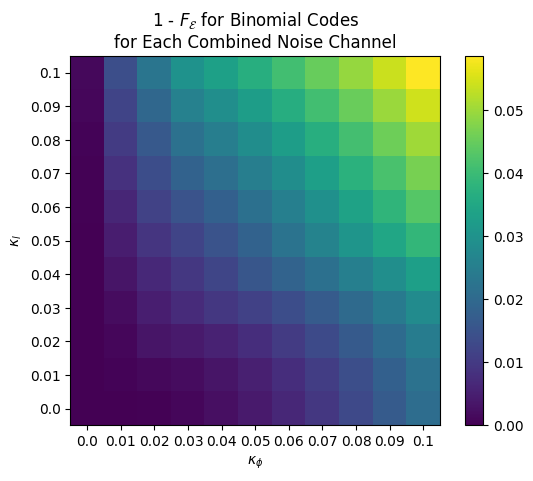

In [4]:
best_binomial_fidelities_per_region = np.max(binomial_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_binomial_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Binomial Codes\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Binomial Code Parameters for Each Region

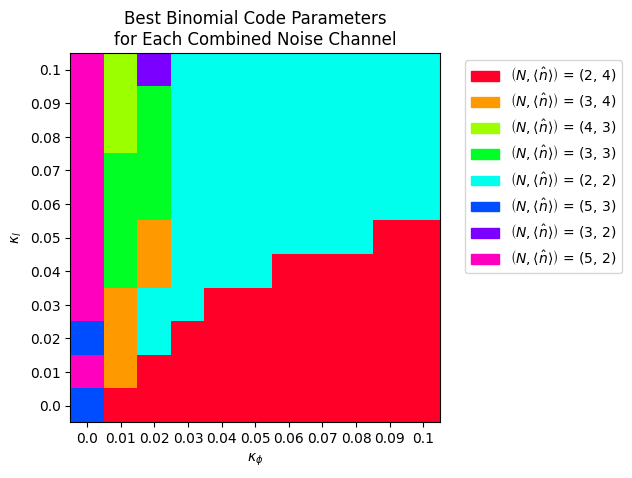

In [5]:
best_parameters = [[None for _ in dephasing_noise_values] for _ in loss_noise_values]
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		fidelities_in_region = binomial_fidelities[i,j]
		maximizing_indices = np.unravel_index(fidelities_in_region.argmax(), fidelities_in_region.shape)
		best_parameters[i][j] = (rotation_symmetries[maximizing_indices[0]], average_photon_numbers[maximizing_indices[1]])
unique_best_parameters = list(set([parameter for parameter_list in best_parameters for parameter in parameter_list]))
parameter_to_data = {value: index for index, value in enumerate(unique_best_parameters)}
image_data = np.array([[parameter_to_data[parameter] for parameter in sublist] for sublist in best_parameters])

plt.figure()
imshow = plt.imshow(image_data, origin="lower", interpolation="none", cmap="gist_rainbow")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Best Binomial Code Parameters\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
used_colors = [imshow.cmap(imshow.norm(value)) for value in range(len(unique_best_parameters))]
patches = [matplotlib.patches.Patch(color=used_colors[i], label=f"$\\left(N, \\langle\\hat n\\rangle\\right)$ = {unique_best_parameters[i]}") for i in range(len(unique_best_parameters))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

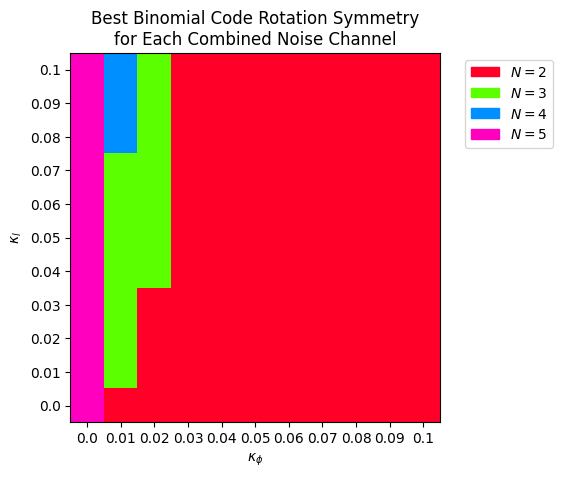

In [6]:
stripped_image_data = [[rotation_symmetry for rotation_symmetry, _ in sublist] for sublist in best_parameters]
unique_good_rotation_symmetries = list(set([rotation_symmetry for sublist in stripped_image_data for rotation_symmetry in sublist]))

plt.figure()
imshow = plt.imshow(stripped_image_data, origin="lower", interpolation="none", cmap="gist_rainbow")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Best Binomial Code Rotation Symmetry\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
used_colors = [imshow.cmap(imshow.norm(rotation_symmetry)) for rotation_symmetry in unique_good_rotation_symmetries]
patches = [matplotlib.patches.Patch(color=used_colors[i], label=f"$N = {unique_good_rotation_symmetries[i]}$") for i in range(len(unique_good_rotation_symmetries))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

### Fidelities for Two-Expanded Haar Random Codes

The shape of `all_random_fidelities` does not match the shape of `binomial_fidelities`. The random fidelities variable has an extra dimension for each trial.

In [7]:
%%time

def make_random_code(rotation_symmetry, average_photon_number):
	dimension = (average_photon_number + 2) * rotation_symmetry
	return code.make_two_expanded_haar_random_code(rotation_symmetry, average_photon_number, dimension)
all_random_fidelities = code_simulator.run_parameter_sweep_for_optimal_fidelities(code_parameters, noise_parameters, make_random_code, make_combined_loss_channel, number_of_random_code_trials)

CPU times: user 54min 24s, sys: 1min 40s, total: 56min 5s
Wall time: 1h 1min 19s


### Random Code Optimal Fidelities in Each Region

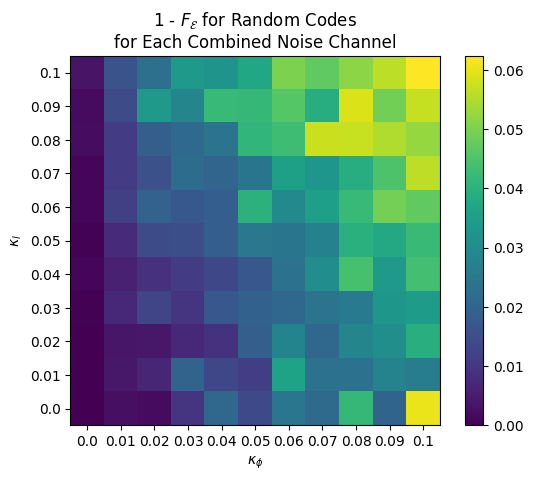

In [8]:
best_random_fidelities_per_region = np.max(all_random_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_random_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Random Codes\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Code in Each Region

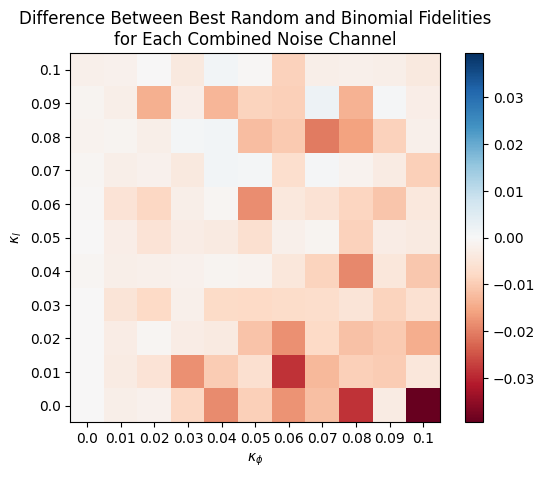

In [9]:
fidelity_difference = best_random_fidelities_per_region - best_binomial_fidelities_per_region

cmap = plt.get_cmap("RdBu")
most_extreme_fidelity_difference = max(np.max(fidelity_difference), np.max(-fidelity_difference))
normalizer = matplotlib.colors.Normalize(-most_extreme_fidelity_difference, most_extreme_fidelity_difference)

plt.figure()
plt.imshow(fidelity_difference, origin="lower", cmap=cmap, norm=normalizer)
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Difference Between Best Random and Binomial Fidelities\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())
plt.show()